<a href="https://colab.research.google.com/github/PaulYogesh/Mic-hackathon-2025/blob/main/NN_based_SEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# @title Install dependencies (if needed)
# ===============================================================
# !pip install scikit-image tensorflow matplotlib
#!pip install -q segmentation-models
#!pip install tensorflow-advanced-segmentation-models
#!pip install -q keras-cv
!pip install -q keras-hub


In [24]:

# @title Import libraries
#import keras_cv
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras_hub
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import re
from skimage import measure, morphology, filters
np.random.seed(0)
tf.random.set_seed(0)


Saving 100 um.png to 100 um (1).png
Using FOV: 100.0 μm


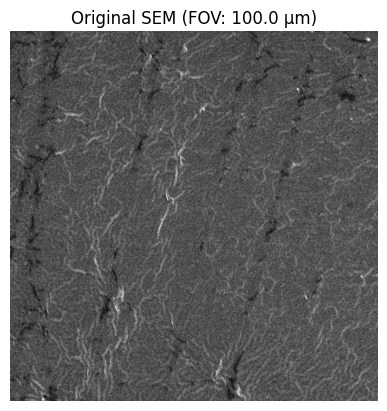

Width: 562, Height: 565, Total Pixels: 317530


In [25]:
# @title Upload SEM image (same as before)

uploaded = files.upload()
fname = next(iter(uploaded))

# Extract FOV from filename
match = re.search(r'(\d+(?:\.\d+)?)\s*um', fname.lower())
FOV_UM = float(match.group(1)) if match else 10.0
print(f"Using FOV: {FOV_UM} μm")

img = Image.open(fname).convert("L")
sem_image = np.array(img)

H, W = sem_image.shape

plt.imshow(sem_image, cmap="gray")
plt.title(f"Original SEM (FOV: {FOV_UM} μm)")
plt.axis("off")
plt.show()

 # Ensure image is uint8//
sem_image = sem_image.astype(np.uint8)

  # Image dimensions//
height_pixels, width_pixels = sem_image.shape; # Extract height and width.
total_pixels = width_pixels * height_pixels;
print(f"Width: {width_pixels}, Height: {height_pixels}, Total Pixels: {total_pixels}");

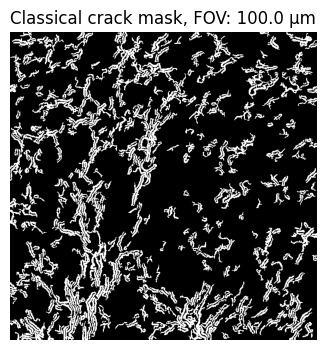

In [26]:
# @title Classical segmentation (for labels + baseline metrics)
def classical_crack_segmentation(sem_image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(sem_image)


    # Noise reduction using Gaussian blur #
    blurred_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0);
    #Sobel edge detection #
    edges_sobel = filters.sobel(blurred_image);
    # Thresholding
    threshold_value = filters.threshold_otsu(edges_sobel);
    binary_image = edges_sobel > threshold_value;
    # Remove small objects to clean up binary image
    cleaned_image = morphology.remove_small_objects(binary_image, min_size=50);
    # Label the objects in the binary image
    labeled_image, num_features = measure.label(cleaned_image, return_num=True, connectivity=2);

    return cleaned_image

binary_classical = classical_crack_segmentation(sem_image)

plt.figure(figsize=(4,4))
plt.imshow(binary_classical, cmap="gray")
plt.axis("off")
plt.title(f"Classical crack mask, FOV: {FOV_UM} μm")
plt.show()

In [27]:
# @title Crack metrics (shared for classical & NN)
def compute_crack_metrics(binary_mask, FOV_um):
    binary_mask = binary_mask.astype(bool)

    Hm, Wm = binary_mask.shape
    T_P = Wm * Hm
    pixel_size = FOV_um / Wm  # µm/pixel

    labeled, N_C = measure.label(binary_mask, connectivity=2, return_num=True)
    regions = measure.regionprops(labeled)

    L_px = sum(r.perimeter for r in regions)
    L_um = L_px * pixel_size

    A_px = sum(r.area for r in regions)
    A_um2 = A_px * (pixel_size ** 2)

    C_px   = N_C / T_P
    C_um2  = N_C / (FOV_um ** 2)
    C_px_s = N_C / A_px if A_px > 0 else 0.0
    C_um2s = N_C / A_um2 if A_um2 > 0 else 0.0
    print(f"Total Width: {Wm}")
    print(f"Pixel width: {pixel_size}")
    print(f"Field of view (FOV): {FOV_um:.1f} µm")
    print(f"Pixel size: 0.0301 µm/pixel (fixed from FOV/width)")
    print(f"Number of microcracks (N_C): {N_C}")
    print(f"Total crack length (L_px): {L_px:.2f} pixels")
    print(f"Total crack length (L_µm): {L_um:.2f} µm")
    print(f"Total cracked area (A_px): {A_px:.2f} pixels")
    print(f"Total cracked area (A_µm²): {A_um2:.2f} µm²")
    print(f"Crack density per pixel (C_px): {C_px:.6e} pixel⁻¹")
    print(f"Crack density per unit area (C_µm⁻²): {C_um2:.6e} µm⁻²")
    print(f"Crack count per cracked pixel area (C*_px): {C_px_s:.6e}")
    print(f"Crack count per cracked area (C*_µm⁻²): {C_um2s:.6e}")

    return {
        "N_C": N_C,
        "L_px": L_px, "L_um": L_um,
        "A_px": A_px, "A_um2": A_um2,
        "C_px": C_px, "C_um2": C_um2,
        "C_px_star": C_px_s, "C_um2_star": C_um2s,
        "mask": binary_mask,
    }


print("\n===== Classical metrics =====")
metrics_classical = compute_crack_metrics(binary_classical, FOV_UM)




===== Classical metrics =====
Total Width: 562
Pixel width: 0.17793594306049823
Field of view (FOV): 100.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 227
Total crack length (L_px): 41428.79 pixels
Total crack length (L_µm): 7371.67 µm
Total cracked area (A_px): 58763.00 pixels
Total cracked area (A_µm²): 1860.51 µm²
Crack density per pixel (C_px): 7.148931e-04 pixel⁻¹
Crack density per unit area (C_µm⁻²): 2.270000e-02 µm⁻²
Crack count per cracked pixel area (C*_px): 3.862975e-03
Crack count per cracked area (C*_µm⁻²): 1.220097e-01


In [28]:
# @title Pad image & mask to multiples of 16 for U-Net
H2 = ((H + 15) // 16) * 16
W2 = ((W + 15) // 16) * 16

pad_H = H2 - H
pad_W = W2 - W

sem_pad = np.pad(sem_image, ((0, pad_H), (0, pad_W)), mode="edge")
mask_pad = np.pad(binary_classical, ((0, pad_H), (0, pad_W)), mode="edge")


In [29]:
# @title Prepare tensors (3‑channel for ResNet)
X = sem_pad.astype(np.float32) / 255.0
X = np.stack([X, X, X], axis=-1)   # grayscale → RGB
y = mask_pad.astype(np.float32)[..., None]

X = X[None, ...]
y = y[None, ...]

print("Training shapes:", X.shape, y.shape)


Training shapes: (1, 576, 576, 3) (1, 576, 576, 1)


In [30]:
# @title KerasCV ResNet18 encoder (Phase 1)
encoder = keras_hub.models.ResNetBackbone.from_preset(
    "resnet_18_imagenet",
    input_shape=(H2, W2, 3)
)

# Freeze encoder initially
encoder.trainable = False


In [31]:
# @title Extract multi‑scale features (skip connections)
s1 = encoder.get_layer("stack0_block1_out").output   # /4
s2 = encoder.get_layer("stack1_block1_out").output   # /8
s3 = encoder.get_layer("stack2_block1_out").output   # /16
b  = encoder.get_layer("stack3_block1_out").output   # /32

In [32]:

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

x = tf.keras.layers.UpSampling2D()(b)
x = tf.keras.layers.Concatenate()([x, s3])
x = conv_block(x, 256)

x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Concatenate()([x, s2])
x = conv_block(x, 128)

x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Concatenate()([x, s1])
x = conv_block(x, 64)

x = tf.keras.layers.UpSampling2D()(x) # Upsample from /4 to /2
x = tf.keras.layers.UpSampling2D()(x) # Upsample from /2 to original (H2, W2)
outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(x)

model = Model(encoder.input, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_co… │ (None, None,      │     36,864 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_bn  │ (None, None,      │        256 │ stack0_block0_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_re… │ (None, None,      │          0 │ stack0_block0_1_… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_2_co… │ (None, None,      │     36,864 │ stack0_block0_1_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_2_bn  │ (None, None,      │        256 │ stack0_block0_2_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_add   │ (None, None,      │          0 │ pool1_pool[0][0], │
│ (Add)               │ None, 64)         │            │ stack0_block0_2_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_out   │ (None, None,      │          0 │ stack0_block0_ad… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_co… │ (None, None,      │     36,864 │ stack0_block0_ou… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_bn  │ (None, None,      │        256 │ stack0_block1_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_re… │ (None, None,      │          0 │ stack0_block1_1_

 Total params: 14,283,649 (54.49 MB)

 Trainable params: 3,097,537 (11.82 MB)

 Non-trainable params: 11,186,112 (42.67 MB)

In [33]:
# @title Loss (BCE + Dice)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2*inter + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=lambda yt, yp:
        tf.keras.losses.binary_crossentropy(yt, yp) + dice_loss(yt, yp)
)


In [34]:
# @title Loss refinement (thin‑structure bias)
def focal_loss(y_true, y_pred, gamma=2.0):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    p_t = tf.exp(-bce)
    return tf.reduce_mean((1 - p_t)**gamma * bce)

def combined_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)


In [35]:
# @title Train (prototype)
model.fit(X, y, epochs=30, verbose=1)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 1.3519
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.3354
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3236
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3158
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3108
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3075
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3048
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3020
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2986
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.2945
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2899
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2848
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.2795
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.2741
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.2690
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.2641

In [36]:
# @title  Predict + adaptive threshold
pred = model.predict(X)[0, :, :, 0]

print("NN prob stats:",
      pred.min(), pred.max(), pred.mean())

# Otsu on probability map
thr = filters.threshold_otsu(pred)
binary_nn_full = pred > thr

# crop back to original size
binary_nn = binary_nn_full[:H, :W]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
NN prob stats: 0.051354863 0.9219333 0.25246534


In [37]:
# @title Skeletonize (for comparison)
from skimage.morphology import skeletonize

binary_nn_thin = skeletonize(binary_nn)


In [38]:
# @title Metrics (Classical)
print("\n===== Classical metrics =====")
metrics_classical = compute_crack_metrics(binary_classical, FOV_UM)



===== Classical metrics =====
Total Width: 562
Pixel width: 0.17793594306049823
Field of view (FOV): 100.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 227
Total crack length (L_px): 41428.79 pixels
Total crack length (L_µm): 7371.67 µm
Total cracked area (A_px): 58763.00 pixels
Total cracked area (A_µm²): 1860.51 µm²
Crack density per pixel (C_px): 7.148931e-04 pixel⁻¹
Crack density per unit area (C_µm⁻²): 2.270000e-02 µm⁻²
Crack count per cracked pixel area (C*_px): 3.862975e-03
Crack count per cracked area (C*_µm⁻²): 1.220097e-01


In [39]:
# @title Metrics (raw CNN)
print("\n===== Pretrained CNN metrics =====")
metrics_nn_brod = compute_crack_metrics(binary_nn, FOV_UM)



===== Pretrained CNN metrics =====
Total Width: 562
Pixel width: 0.17793594306049823
Field of view (FOV): 100.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 319
Total crack length (L_px): 21542.28 pixels
Total crack length (L_µm): 3833.15 µm
Total cracked area (A_px): 72672.00 pixels
Total cracked area (A_µm²): 2300.88 µm²
Crack density per pixel (C_px): 1.004629e-03 pixel⁻¹
Crack density per unit area (C_µm⁻²): 3.190000e-02 µm⁻²
Crack count per cracked pixel area (C*_px): 4.389586e-03
Crack count per cracked area (C*_µm⁻²): 1.386424e-01


In [40]:
# @title Metrics (skeletonised)
print("\n===== Pretrained skeleton CNN metrics =====")
metrics_nn_crack = compute_crack_metrics(binary_nn_thin, FOV_UM)



===== Pretrained skeleton CNN metrics =====
Total Width: 562
Pixel width: 0.17793594306049823
Field of view (FOV): 100.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 319
Total crack length (L_px): 11160.88 pixels
Total crack length (L_µm): 1985.92 µm
Total cracked area (A_px): 10862.00 pixels
Total cracked area (A_µm²): 343.90 µm²
Crack density per pixel (C_px): 1.004629e-03 pixel⁻¹
Crack density per unit area (C_µm⁻²): 3.190000e-02 µm⁻²
Crack count per cracked pixel area (C*_px): 2.936844e-02
Crack count per cracked area (C*_µm⁻²): 9.275846e-01


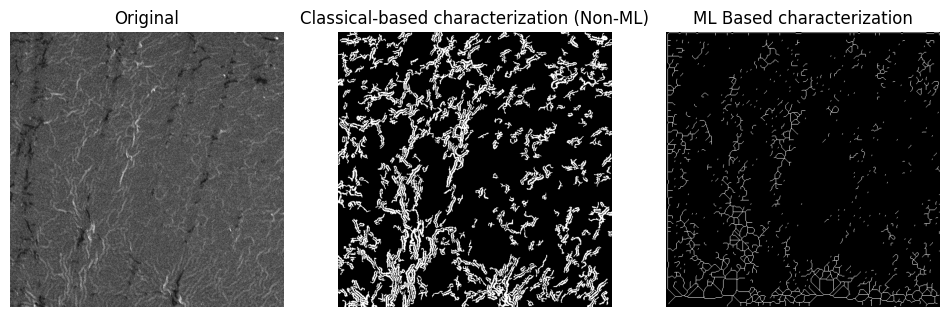

In [45]:
# @title Visualization (same as before)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(sem_image, cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Classical-based characterization (Non-ML)")
plt.imshow(binary_classical, cmap='gray')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("ML Based characterization")
plt.imshow(metrics_nn_crack['mask'], cmap='gray')
plt.axis("off")

plt.show()